In [1]:
import numpy as np
import math
import scipy as sci
from qiskit import *
from qiskit import IBMQ
from qiskit.tools.monitor import *
from qiskit.tools.visualization import *

In [2]:
%matplotlib inline

In [3]:
def Binary2(i, N):
    s = ''
    
    while i!=0:
        r = i%2
        s += str(r);
        i = (i-r)//2
        
    s += (N - len(s))*'0'
    
    return s

def WaveFunction(obj, *args, **kwargs):
    if(type(obj) == QuantumCircuit):
        statevec = execute(obj, Aer.backends(name='statevector_simulator')[0], shots=1).result().get_statevector()
    elif(type(obj) == np.ndarray):
        statevec = obj
    else:
        return
    
    # print(statevec)
    
    sys = False
    NL = False
    dec = 5
    
    if 'precision' in kwargs:
        dec = int(kwargs['precision'])
    if 'column' in kwargs:
        NL = kwargs['column']
    if 'systems' in kwargs:
        sys = True
        systems = kwargs['systems']
        last_sys = int(len(systems)-1)
        show_systems = []
        
        for it in systems:
            if(type(it)!=int):
                raise Exception('Somente inteiros!')
        
        if 'show_systems' in kwargs:
            show_systems = kwargs['show_systems']
            
            if(len(show_systems) != len(systems)):
                raise Exeption('show_systems e systems tem que ter o mesmo tamanho')
            
            for i in range(len(show_systems)):
                it = show_systems[i]
                if(type(it)!=bool):
                    raise Exeption('Somente booleanos')
                if it:
                    last_sys = int(i)
        else:
            for i in range(len(systems)):
                show_systems.append(True)
                
    wave = ''
    n = int(math.log(len(statevec), 2))
    N = int(2**n)
    for i in range(len(statevec)):
        value = round(statevec[i].real, dec) + round(statevec[i].imag, dec)*1j
        
        if (value.real!=0) or (value.imag!=0):
            state = list(Binary2(i, n))
            state_str = ''
            
            if sys:
                k = 0
                for s in range(len(systems)):
                    if show_systems[s]:
                        if s != last_sys:
                            state.insert(int(k+systems[s]), '>|')
                            k += systems[s]+1
                        else:
                            k += systems[s]
                    else:
                        for s2 in range(systems[s]):
                            del state[k]
                            
            for j in range(len(state)):
                if(type(state[j]) != str):
                    state_str += str(int(state[i]))
                else:
                    state_str += state[j]
            if (value.real!=0) and (value.imag!=0):
                if(value.imag > 0):
                    wave += str(value.real) + '+' + str(value.imag) + 'i |' + state_str + '> '
                else:
                    wave += str(value.real) + str(value.imag) + 'i |' + state_str + '> '
            if (value.real!=0) and (value.imag==0):
                wave += str(value.real) + ' |' + state_str + '> '
            if (value.real==0) and (value.imag!=0):
                wave += str(value.imag) + 'i |' + state_str + '> '
            if(NL):
                wave += '\n'
    print(wave)

In [4]:
i0 = '0011'

n = len(i0)
ctrl = QuantumRegister(n, 'ctrl')
if n > 2:
    auxl = QuantumRegister(n-1, 'auxl')
targ = QuantumRegister(1, 'targ')
clas = ClassicalRegister(n, 'clas')
if n > 2:
    circuit = QuantumCircuit(ctrl, auxl, targ, clas)
else:
    circuit = QuantumCircuit(ctrl, targ, clas)


# ---------- Initial State ------------ #
for i in range(n):
    circuit.h(ctrl[i]);
    
circuit.x(targ[0]);
circuit.h(targ[0]);

circuit.barrier();


# ---------- Grover Circuit ------------ #
t = math.floor(math.pi/4.0 * math.sqrt(2**n))
for _ in range(t):
    # ---------- Oraculo ------------ #
    for k in range(n):
        if i0[k] == '0':
            circuit.x(ctrl[k])
    circuit.barrier();
    
    if n == 2:
        circuit.ccx(ctrl[0], ctrl[1], targ[0])
    else:    
        circuit.ccx(ctrl[0], ctrl[1], auxl[0])
        for i in range(2, n):
            circuit.ccx(ctrl[i], auxl[i-2], auxl[i-1])

        circuit.cx(auxl[n-2], targ[0])

        for i in range(n-1, 1, -1):
            circuit.ccx(ctrl[i], auxl[i-2], auxl[i-1])
        circuit.ccx(ctrl[0], ctrl[1], auxl[0])
    
    circuit.barrier();
    for k in range(len(i0)):
        if i0[k] == '0':
            circuit.x(ctrl[k])
    circuit.barrier(); 
    
    # ---------- inversion about the mean ------------ #
    
    for i in range(n):
        circuit.h(ctrl[i]);
        circuit.x(ctrl[i]);
    circuit.barrier();
    
    circuit.s(ctrl[0]) 
    circuit.x(ctrl[0]) 
    circuit.s(ctrl[0])
    circuit.x(ctrl[0])
    circuit.h(ctrl[n-1])
    circuit.barrier();
    
    if n == 2:
        circuit.cx(ctrl[0], ctrl[1]);
    elif n == 3:
        circuit.ccx(ctrl[0], ctrl[1], ctrl[2])
    else:
        circuit.ccx(ctrl[0], ctrl[1], auxl[0])
        for i in range(2, n-1):
            circuit.ccx(ctrl[i], auxl[i-2], auxl[i-1])
        circuit.cx(auxl[n-3], ctrl[n-1])
        for i in range(n-2, 1, -1):
            circuit.ccx(ctrl[i], auxl[i-2], auxl[i-1])
        circuit.ccx(ctrl[0], ctrl[1], auxl[0])
        
    circuit.barrier();
    
    circuit.x(ctrl[0])
    circuit.sdg(ctrl[0]) 
    circuit.x(ctrl[0]) 
    circuit.sdg(ctrl[0])
    circuit.h(ctrl[n-1])
    circuit.barrier();
    
    for i in range(n):
        circuit.x(ctrl[i]);
        circuit.h(ctrl[i]);
    circuit.barrier();    
    

    
# ---------- Measurement ------------ #
if n == 2:
    WaveFunction(circuit, column = True, systems = [n, 1], show_systems = [True, True])
else:
    WaveFunction(circuit, column = True, systems = [n,n-1,1], show_systems = [True, False, True])
circuit.measure(ctrl, clas);

0.03591 |0000>|0> 
0.03591 |1000>|0> 
0.03591 |0100>|0> 
0.03591 |1100>|0> 
0.03591 |0010>|0> 
0.03591 |1010>|0> 
0.03591 |0110>|0> 
0.03591 |1110>|0> 
0.03591 |0001>|0> 
0.03591 |1001>|0> 
0.03591 |0101>|0> 
0.03591 |1101>|0> 
-0.6933 |0011>|0> 
0.03591 |1011>|0> 
0.03591 |0111>|0> 
0.03591 |1111>|0> 
-0.03591 |0000>|1> 
-0.03591 |1000>|1> 
-0.03591 |0100>|1> 
-0.03591 |1100>|1> 
-0.03591 |0010>|1> 
-0.03591 |1010>|1> 
-0.03591 |0110>|1> 
-0.03591 |1110>|1> 
-0.03591 |0001>|1> 
-0.03591 |1001>|1> 
-0.03591 |0101>|1> 
-0.03591 |1101>|1> 
0.6933 |0011>|1> 
-0.03591 |1011>|1> 
-0.03591 |0111>|1> 
-0.03591 |1111>|1> 



In [ ]:
circuit.draw(output='mpl')
# print(circuit.qasm())

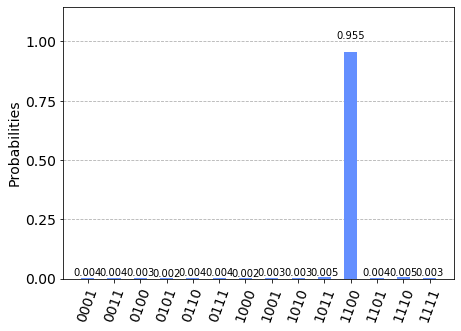

In [5]:
# ---------- Simulator ------------ #

simulator = BasicAer.get_backend('qasm_simulator')
job = execute(circuit, simulator)
result = job.result()
plot_histogram(result.get_counts())

In [ ]:
# ---------- IBMQ --------------
provedor.backends()
maquina = provedor.get_backend('ibmq_rome')
job = execute(circuit, maquina, shots=4096)
job_monitor(job)
result = job.result()
plot_histogram(result.get_counts())